# Deep Learning Classification of fdom Anomaly Peaks with Resnet
Using k-fold validation

In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing
from Anomaly_Detection.Deep_Learning.resnet import ResNet1D
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from Anomaly_Detection.Deep_Learning.datasets import fdomDataset, collate_fn_pad, fdomAugOnlyDataset
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
)
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from functools import partial


In [2]:
# util functions
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            print(f"reset trainable params of layer = {layer}")
            layer.reset_parameters()


## Hyperparameters
Adjust as needed!

In [3]:
# Hyperparams
WINDOW_SIZE = 15  # the size of each data segment
SEED = 42
BATCH_SIZE = 32

# this is the number of epochs per fold, but because data is already batched,
# when larger than 1, training takes a long time, make sure you have cuda for fast training
EPOCHS = 5

SPLITS = 5


In [4]:
# Paths to data files
fdom_raw_data = (
    "Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
)
stage_raw_data = "Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = (
    "Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)
fdom_labeled = "Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"

# augmented files
fdom_raw_augmented = "Data/augmented_data/fdom/unlabeled/unlabeled_fdom.csv"
fdom_labeled_augmented = "Data/augmented_data/fdom/labeled/labeled_fdom_peaks.csv"
turb_augmented_raw_data = "Data/augmented_data/fdom/unlabeled/unlabeled_turb.csv"
stage_augmented_data_fn = "Data/augmented_data/fdom/unlabeled/unlabeled_stage.csv"

fdom_fpt_lookup_path = "Data/augmented_data/fdom/fpt_lookup.csv"
fdom_fsk_lookup_path = "Data/augmented_data/fdom/fsk_lookup.csv"

In [5]:
# get device (cpu or cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Create Dataset
Use the custom dataset class to setup the dataset, classes, and targets

In [6]:
# list of classnames
classes = ["NAP", "FSK", "FPT", "PLP", "PP", "SKP"]

# create label encoder, encode classes into integers
le = preprocessing.LabelEncoder()
targets = le.fit_transform(classes)

# create dataset
# dataset = fdomDataset(
#     le,
#     fdom_raw_data,
#     stage_raw_data,
#     turb_raw_data,
#     fdom_labeled,
#     fdom_raw_augmented,
#     stage_augmented_data_fn,
#     turb_augmented_raw_data,
#     fdom_labeled_augmented,
# )


In [7]:
# this is purely for class balanced TESTING if we want to do that
dataset = fdomAugOnlyDataset(
    le,
    fdom_raw_augmented,
    stage_augmented_data_fn,
    turb_augmented_raw_data,
    fdom_labeled_augmented,
    window_size=WINDOW_SIZE,
    fpt_lookup_filename=fdom_fpt_lookup_path,
    fsk_lookup_filename=fdom_fsk_lookup_path,
)

3764 candidates found.


## Setup KFold cross validation

In [8]:
torch.manual_seed(42)
results = {}

tss = TimeSeriesSplit(SPLITS)

criterion = nn.CrossEntropyLoss().to(device)

## Training
Train the model, and print out simple accuracy results.

In [9]:
# K-fold training
conf_matrices = {}
accumulated_metrics = {}

for fold, (train_ids, test_ids) in enumerate(tss.split(dataset)):
    print(f"FOLD {fold}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler,
        collate_fn=partial(collate_fn_pad, device=device),
    )

    testloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=test_subsampler,
        collate_fn=partial(collate_fn_pad, device=device),
    )

    # init model
    model = ResNet1D(
        in_channels=4,
        base_filters=64,
        kernel_size=16,
        stride=2,
        n_block=48,
        groups=1,  # check this
        n_classes=len(classes),
        downsample_gap=6,
        increasefilter_gap=12,
        verbose=False,
    ).to(device)

    # set model to use float instead of doubles to prevent errors
    model = model.float()

    # init optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(0, EPOCHS):
        print(f"Starting epoch {epoch + 1}")

        current_loss = 0

        # prog bar
        prog_bar = tqdm(trainloader, desc="Training", leave=False)
        for i, data in enumerate(prog_bar):
            x = data[0].to(device)
            y = data[1].squeeze().to(device)

            optimizer.zero_grad()

            pred = model(x.float())
            loss = criterion(pred, y)

            loss.backward()
            optimizer.step()

            # print stats
            current_loss += loss.item()
            if i % 500 == 499:
                print("Loss after mini-batch %5d: %.3f" % (i + 1, current_loss / 500))
                current_loss = 0.0

    # completed training, now test
    print(f"Training for fold {fold} has completed, now testing")

    # save best params
    save_path = f"Anomaly_Detection/Deep_Learning/results/fdom/models/kfold/model-balanced-test-fold={fold}.pth"
    torch.save(model.state_dict(), save_path)

    total, correct = 0, 0

    # for checking correct and incorrect preds
    y_true = []
    y_pred = []

    prog_bar = tqdm(testloader, desc="Testing", leave=False)
    with torch.no_grad():
        for i, data in enumerate(prog_bar):
            x = data[0].to(device)
            y = data[1].squeeze().to(device)

            outputs = model(x.float())

            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(y, preds):
                # convert label and prediction to current vals
                label = label.to('cpu')
                prediction = prediction.to('cpu')
                label = le.inverse_transform([label])[0]
                prediction = le.inverse_transform([prediction])[0]

                # for confusion matrices
                y_pred.append(prediction)
                y_true.append(label)

                if label == prediction:
                    correct += 1
                total += 1

        # Print rough general accuracy
        print("Accuracy for fold %d: %d %%" % (fold, 100.0 * correct / total))
        print("--------------------------------")
        results[fold] = 100.0 * (correct / total)

        # make classification report
        acc_report = classification_report(y_true, y_pred)
        print(acc_report)

        # get acc score
        acc_score = accuracy_score(y_true, y_pred)

        bal_acc = balanced_accuracy_score(y_true, y_pred)

        f1 = f1_score(
            y_true,
            y_pred,
            average="weighted",
        )

        precision = precision_score(
            y_true,
            y_pred,
            average="weighted",
        )

        # make conf matrix
        matrix = confusion_matrix(y_true, y_pred, labels=classes)

        # save conf matrix
        conf_matrices[fold] = copy.deepcopy(matrix)

        # save accumulated metrics
        accumulated_metrics[fold] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

# Print fold results
print("\n")
print(f"K-FOLD CROSS VALIDATION RESULTS FOR {SPLITS} FOLDS")
print("--------------------------------")
sum = 0.0
for key, value in results.items():
    print(f"Fold {key}: {value} %")
    sum += value
print(f"Average: {sum/len(results.items())} %")


FOLD 0
Starting epoch 1


Training:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\clayk\Projects\srrw-peak-detection\Anomaly_Detection\Deep_Learning\datasets.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  label_list = torch.tensor(label_list, dtype=torch.int64)


Starting epoch 2


Starting epoch 3


Starting epoch 4


Starting epoch 5


Training for fold 0 has completed, now testing


Accuracy for fold 0: 74 %
--------------------------------
              precision    recall  f1-score   support

         FPT       0.99      1.00      1.00       139
         FSK       1.00      1.00      1.00       138
         NAP       0.36      0.19      0.25        83
         PLP       0.50      1.00      0.66        97
          PP       0.71      0.84      0.77        87
         SKP       0.83      0.06      0.11        83

    accuracy                           0.75       627
   macro avg       0.73      0.68      0.63       627
weighted avg       0.77      0.75      0.70       627

FOLD 1
Starting epoch 1


Starting epoch 2


Starting epoch 3


Starting epoch 4


Starting epoch 5


Training for fold 1 has completed, now testing


Accuracy for fold 1: 77 %
--------------------------------
              precision    recall  f1-score   support

         FPT       1.00      1.00      1.00       141
         FSK       1.00      1.00      1.00       142
         NAP       0.00      0.00      0.00        84
         PLP       0.49      1.00      0.65        91
          PP       0.75      0.95      0.84        95
         SKP       0.66      0.28      0.40        74

    accuracy                           0.77       627
   macro avg       0.65      0.71      0.65       627
weighted avg       0.71      0.77      0.72       627

FOLD 2
Starting epoch 1


Starting epoch 2


Starting epoch 3


Starting epoch 4


Starting epoch 5


Training for fold 2 has completed, now testing


Accuracy for fold 2: 77 %
--------------------------------
              precision    recall  f1-score   support

         FPT       1.00      1.00      1.00       138
         FSK       1.00      1.00      1.00       138
         NAP       0.67      0.02      0.04        88
         PLP       0.53      1.00      0.69        98
          PP       0.65      1.00      0.79        80
         SKP       0.82      0.38      0.52        85

    accuracy                           0.78       627
   macro avg       0.78      0.73      0.67       627
weighted avg       0.81      0.78      0.72       627

FOLD 3
Starting epoch 1


Starting epoch 2


Starting epoch 3


Starting epoch 4


Starting epoch 5


Training for fold 3 has completed, now testing


c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\miniconda3\envs\srrw\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clayk\minicon

Accuracy for fold 3: 80 %
--------------------------------
              precision    recall  f1-score   support

         FPT       1.00      1.00      1.00       139
         FSK       1.00      1.00      1.00       140
         NAP       0.00      0.00      0.00        83
         PLP       0.59      1.00      0.74        98
          PP       0.67      0.99      0.80        92
         SKP       0.74      0.47      0.57        75

    accuracy                           0.80       627
   macro avg       0.67      0.74      0.69       627
weighted avg       0.73      0.80      0.75       627

FOLD 4
Starting epoch 1


ValueError: Expected input batch_size (1) to match target batch_size (0).

Mean Test F1:  0.7226021597589052
Mean Test BA:  0.7157599864671311
Mean Test Acc:  0.7751196172248804
Mean Test Precision:  0.7553791088476125


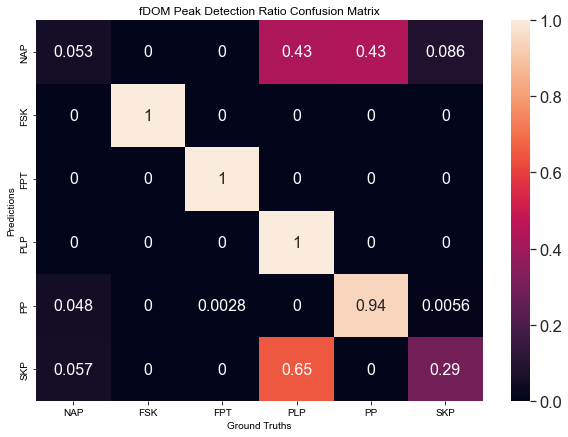

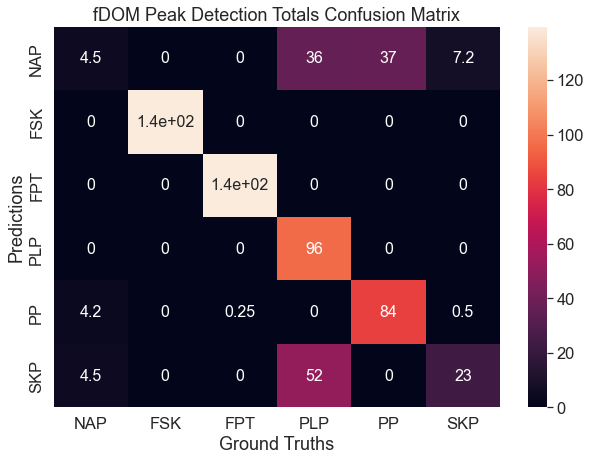

In [10]:
# save accumulated metrics
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_metrics:
    metrics = accumulated_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_metrics))

# make mean confusion matrix
mean_cfmx = np.zeros((len(classes), len(classes)))
for key in conf_matrices.keys():
    mean_cfmx += conf_matrices[key]

mean_cfmx = mean_cfmx / len(conf_matrices)

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Ratio Confusion Matrix")

sn.set(font_scale=1.5)

plot = sn.heatmap(
    pd.DataFrame(
        mean_cfmx.astype("float") / mean_cfmx.sum(axis=1)[:, np.newaxis],
        index=classes,
        columns=classes,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()

plot.get_figure().savefig(
    "Anomaly_Detection/Deep_Learning/results/fdom/graphics/may-11-conf-ratio-balanced-test-kfold.png"
)

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Totals Confusion Matrix")

sn.set(font_scale=1.5)

plot = sn.heatmap(
    pd.DataFrame(
        mean_cfmx,
        index=classes,
        columns=classes,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()

plot.get_figure().savefig(
    "Anomaly_Detection/Deep_Learning/results/fdom/graphics/may-11-conf-totals-balanced-test-kfold.png"
)

In [ ]:
# save plots and metrics
